In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import S3dis
from data_aug import *
from pointmeta import PointMeta
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_aug = Compose([ColorContrast(p=0.2),
                         PointCloudScaling(0.9, 1.1),
                         PointCloudFloorCentering(),
                         PointCloudRotation_Z(1.0, False),
                         PointCloudJitter(0.005, 0.02),
                         ColorDrop(p=0.2),
                         ColorNormalize()])
train_dataset = S3dis('/mnt/Disk16T/chenhr/threed_data/data/processed_s3dis', split='train', loop=30, npoints=24000, transforms=train_aug)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)

In [3]:
device = 'cuda:0'

seg_model = PointMeta(13, 4, 32, [4, 8, 4, 4]).to(device)
seg_model.load_state_dict(torch.load('/mnt/Disk16T/chenhr/VAE-CVAE-MNIST/seg/pointmeta_seg_0001lr.pth', map_location=device)['model_state_dict'])

<All keys matched successfully>

In [4]:
def gen_color(y):
    """
    y.shape = (n,)
    """
    color_map = [[0, 255, 0], [0, 0, 255], [136, 206, 250],
                 [255, 255, 0], [255, 0, 255], [255, 0, 0],
                 [107, 142, 35], [255, 165, 0], [153, 50, 204],
                 [139, 26, 26], [0, 100, 0], [156, 156, 156], [0, 0, 0]]
    color_map = np.asarray(color_map, dtype=np.float32)
    res = np.zeros((len(y), 3))
    for i in range(13):
        mask = (y == i)
        res[mask] = color_map[i]
    return res

In [5]:
seg_model.eval()

feas = []
ys = []

with torch.no_grad():
    for i, (pos, color, y) in enumerate(train_dataloader):
        print(i)
        pos = pos.to(device)
        color = color.to(device)
        y = y.to(device)
        
        _, fea = seg_model(pos, color)
        
        feas.append(fea.to('cpu'))
        ys.append(y.to('cpu'))
        
        if i == 0:
            break

feas = torch.cat(feas, dim=1).squeeze(dim=0)
ys = torch.cat(ys, dim=1).squeeze(dim=0)

0


In [6]:
print(feas.shape, ys.shape)

torch.Size([24000, 64]) torch.Size([24000])


In [7]:
feas, ys = feas.numpy(), ys.numpy()
ys_color = gen_color(ys) / 255

In [8]:
print(feas.shape, ys.shape, ys_color.shape)

(24000, 64) (24000,) (24000, 3)


/home/lindi/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


([], [])

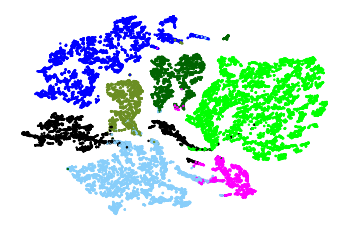

: 

In [11]:
tsne = TSNE(init='pca', learning_rate=200, n_iter=1000, perplexity=50)
low_f = tsne.fit_transform(feas)

plt.scatter(low_f[:, 0], low_f[:, 1], c=ys_color, s=2)
plt.axis('off')
plt.xticks([])
plt.yticks([])
# plt.savefig('./epsc.png', dpi=800)